In [43]:
%load_ext autoreload
%autoreload 2

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from pim.network import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


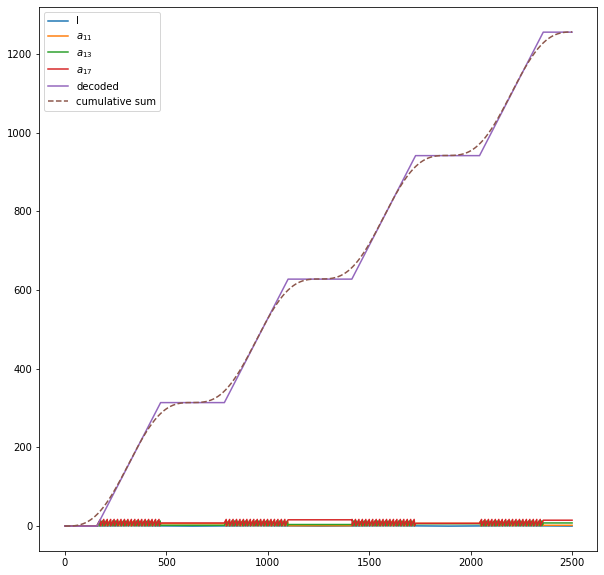

In [262]:
def simulate_counter(N, I, T, noise = 0.0):
    weights = np.hstack([np.ones((N, N))[:,:-1], -1000 * np.ones((N,1))])

    def cell(i):
        threshold = i + 0.5
        def f(inputs):
            I = inputs[0]
            recurrent = (weights[i,:] + np.random.normal(0, noise, N)) @ np.array(inputs[1:])
            return (np.maximum(0, recurrent) + I > threshold)
        return f

    cells = {
        "I": InputLayer(),
        **{
            i: FunctionLayer(
                ["I", *range(N)],
                cell(i)
            )
            for i in range(N)
        }
    }

    network = RecurrentNetwork(cells)
    #nx.draw(network.get_graph(), with_labels=True)

    outputs = []
    T = range(T)

    for t in T:
        network.layers["I"].set(I[t])
        network.step(1.0)
        outputs.append([network.output(i)[0] for i in range(N)] + np.random.normal(0, noise, N))
    
    return outputs


I = -0.5 * np.cos(np.arange(2500) / 100) + 0.5
#I = np.ones(2500)
Isum = np.cumsum(I) - I[0]

# Very noise sensitive :(
a11 = np.sum(simulate_counter(11, I, 2500, 0.0), 1)
a13 = np.sum(simulate_counter(13, I, 2500, 0.0), 1)
a17 = np.sum(simulate_counter(17, I, 2500, 0.0), 1)

m11=6
m13=-5

m143=5
m17=-42

# Decode: https://www.wikiwand.com/en/Chinese_remainder_theorem#/Existence_(constructive_proof)
decoded = ((a11*m13*13 + a13*m11*11)*m17*17 + a17*m143*143) % (11*13*17)
    
plt.figure(figsize=(10, 10))
plt.plot(I, label="I")
plt.plot(a11, label="$a_{11}$")
plt.plot(a13, label="$a_{13}$")
plt.plot(a17, label="$a_{17}$")
plt.plot(decoded, label="decoded")
plt.plot(Isum, "--", label="cumulative sum")
plt.legend()
plt.show()